In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast
import json

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
data_path = 'data/projdata'
metadata = pd.read_csv(os.path.join(data_path, 'movies_metadata.csv'), low_memory=False)

def convert_metadata(metadata):
    metadata['release_date'] = pd.to_datetime(metadata['release_date'], errors='coerce')
    metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
    metadata['revenue'] = pd.to_numeric(metadata['revenue'], errors='coerce')
    metadata['runtime'] = pd.to_numeric(metadata['runtime'], errors='coerce')
    return metadata

metadata = convert_metadata(metadata)

metadata = metadata[pd.notnull(metadata['title'])]
metadata = metadata[pd.notnull(metadata['budget'])]
metadata = metadata[pd.notnull(metadata['revenue'])]
metadata = metadata[pd.notnull(metadata['runtime'])]
metadata = metadata[pd.notnull(metadata['release_date'])]
metadata = metadata[pd.notnull(metadata['overview'])]

metadata['year'] = pd.to_datetime(metadata['release_date'], errors='coerce').dt.year.astype('Int64')
metadata['genre_list'] = metadata['genres'].apply(lambda x: [genre['name'] for genre in ast.literal_eval(x)])
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44435 entries, 0 to 45465
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  44435 non-null  object        
 1   belongs_to_collection  4429 non-null   object        
 2   budget                 44435 non-null  float64       
 3   genres                 44435 non-null  object        
 4   homepage               7749 non-null   object        
 5   id                     44435 non-null  object        
 6   imdb_id                44423 non-null  object        
 7   original_language      44425 non-null  object        
 8   original_title         44435 non-null  object        
 9   overview               44435 non-null  object        
 10  popularity             44435 non-null  object        
 11  poster_path            44128 non-null  object        
 12  production_companies   44435 non-null  object        
 13  produc

In [3]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(metadata['genre_list'])
label_classes = mlb.classes_

label_classes
label_list = []
for elem in label_classes:
  label_list.append(elem)

final_genres = MultiLabelBinarizer(classes = label_list) 
y = final_genres.fit_transform(metadata['genre_list'])
final_genres.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [4]:
X = metadata['title']
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

vectorizer = TfidfVectorizer(stop_words = 'english', lowercase = True)

X_train_vector = vectorizer.fit_transform(X_train)
X_val_vector = vectorizer.transform(X_val)

(35548,) (8887,) (35548, 20) (8887, 20)


In [5]:
def pipeline(model, params = None, cv = 5):
    if params == None:
        model.fit(X_train_vector, y_train)
        return(model, model.predict(X_train_vector), model.predict(X_val_vector))
    else:
        model_cv = GridSearchCV(estimator = model, param_grid = params, cv = cv)
        model_cv.fit(X_train_vector, y_train)
        model = model_cv.best_estimator_
            
        return(model, model.predict(X_train_vector), model.predict(X_val_vector), model_cv)

In [6]:
tree = DecisionTreeClassifier()
model, train_preds, val_preds = pipeline(tree)

target_names = label_list
training_report = classification_report(y_true=y_train, y_pred=train_preds, target_names=target_names)
validation_report = classification_report(y_true=y_val, y_pred=val_preds, target_names=target_names)
train_accuracy = accuracy_score(y_true=y_train, y_pred=train_preds)
validation_accuracy = accuracy_score(y_true=y_val, y_pred=val_preds)
print("Classification Report - Training:\n", training_report)
print("\nClassification Report - Validation:\n", validation_report)
print("\nAccuracy - Training:", train_accuracy)
print("Accuracy - Validation:", validation_accuracy)

Classification Report - Training:
                  precision    recall  f1-score   support

         Action       0.98      0.87      0.92      5260
      Adventure       0.99      0.87      0.92      2781
      Animation       1.00      0.91      0.95      1530
         Comedy       0.99      0.89      0.94     10254
          Crime       0.98      0.82      0.89      3432
    Documentary       1.00      0.89      0.94      3087
          Drama       0.96      0.92      0.94     15994
         Family       0.99      0.89      0.94      2216
        Fantasy       0.99      0.85      0.92      1850
        Foreign       1.00      0.82      0.90      1311
        History       0.99      0.85      0.91      1090
         Horror       0.98      0.87      0.92      3741
          Music       0.99      0.85      0.92      1274
        Mystery       0.99      0.80      0.89      1975
        Romance       0.98      0.83      0.90      5287
Science Fiction       0.99      0.87      0.93      

/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanjana/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sa

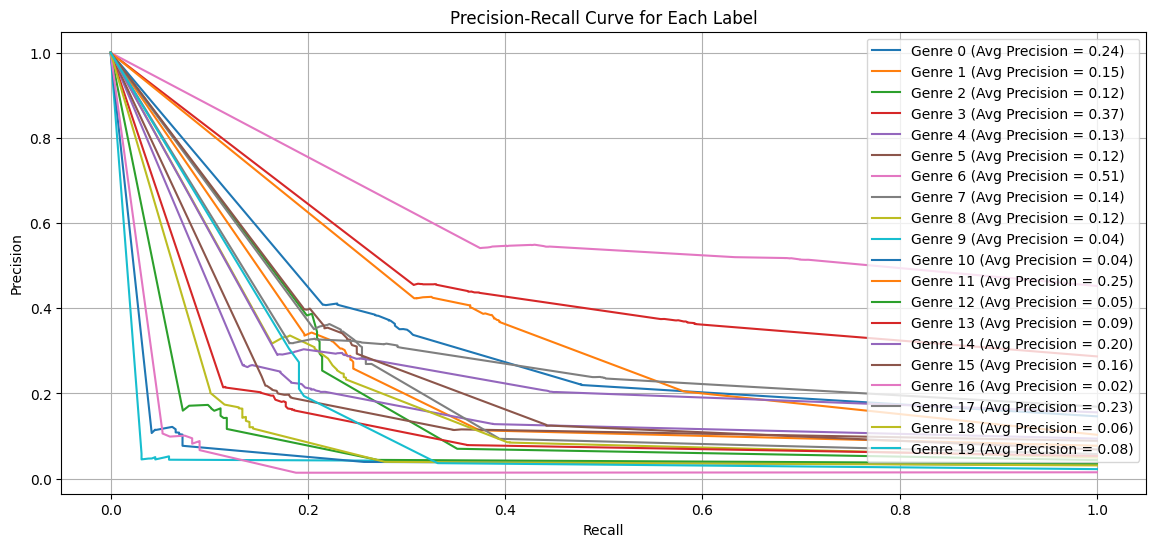

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Assuming you already have a trained decision tree model named 'model'
# and the validation data X_val_vector and y_val

# Predict probabilities for the validation set for each label
y_scores = model.predict_proba(X_val_vector)

# Initialize plot
plt.figure(figsize=(14, 6))

# Iterate through each label
for i in range(y_val.shape[1]):
    y_true = y_val[:, i]
    y_score = y_scores[i][:, 1]  # Probability of the positive class for label i

    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    
    # Calculate average precision score
    average_precision = average_precision_score(y_true, y_score)

    # Plot the precision-recall curve for the label
    plt.plot(recall, precision, label=f'Genre {i} (Avg Precision = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc='best')
plt.grid(True)
plt.show()
